In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
import random

from torchvision import datasets, transforms
from torch import utils

In [27]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def getColor():
    color: int
    color1 = random.randint(16, 255)
    color2 = random.randint(16, 255)
    color3 = random.randint(16, 255)
    color1 = hex(color1)
    color2 = hex(color2)
    color3 = hex(color3)
    ans = "#" + color1[2:] + color2[2:] + color3[2:]
    return ans

mnist_classes = [str(i) for i in range(100)]
colors = [getColor() for i in range(100)]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(100):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = torch.tensor(images[0]).cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

In [12]:
cuda = torch.cuda.is_available()

data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),					#转化为张量
    transforms.Normalize((.5), (.5))	#进行归一化
])

In [13]:
dataset = datasets.ImageFolder('drive/MyDrive/ML_Sp21_Project/100_WebFace', transform=data_transform)
train_length = int(0.8 * len(dataset))
valid_length = len(dataset) - train_length
train, valid= utils.data.random_split(dataset=dataset, lengths=[train_length, valid_length])

In [14]:
# Set up data loaders
from datasets import SiameseImageFolder

siamese_train_dataset = SiameseImageFolder(train, True) # Returns pairs of images and target same/different

# print(siamese_train_dataset.train_labels)
# print(siamese_train_dataset.labels_set)
# print(siamese_train_dataset.label_to_indices)
siamese_test_dataset = SiameseImageFolder(valid, False)
batch_size = 64
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 100
log_interval = 100

tensor([45, 88, 15,  ..., 94, 57, 67])


In [15]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/1617 (0%)]	Loss: 0.244236
Epoch: 1/100. Train set: Average loss: 0.1930
Epoch: 1/100. Validation set: Average loss: 0.1303
Train: [0/1617 (0%)]	Loss: 0.137545
Epoch: 2/100. Train set: Average loss: 0.1517
Epoch: 2/100. Validation set: Average loss: 0.1564
Train: [0/1617 (0%)]	Loss: 0.172366
Epoch: 3/100. Train set: Average loss: 0.1485
Epoch: 3/100. Validation set: Average loss: 0.1277
Train: [0/1617 (0%)]	Loss: 0.129651
Epoch: 4/100. Train set: Average loss: 0.1423
Epoch: 4/100. Validation set: Average loss: 0.1365
Train: [0/1617 (0%)]	Loss: 0.140320
Epoch: 5/100. Train set: Average loss: 0.1422
Epoch: 5/100. Validation set: Average loss: 0.1411
Train: [0/1617 (0%)]	Loss: 0.159593
Epoch: 6/100. Train set: Average loss: 0.1406
Epoch: 6/100. Validation set: Average loss: 0.1389
Train: [0/1617 (0%)]	Loss: 0.132218
Epoch: 7/100. Train set: Average loss: 0.1322
Epoch: 7/100. Validation set: Average loss: 0.1402
Train: [0/1617 (0%)]	Loss: 0.138453
Epoch: 8/100. Train set: Average 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


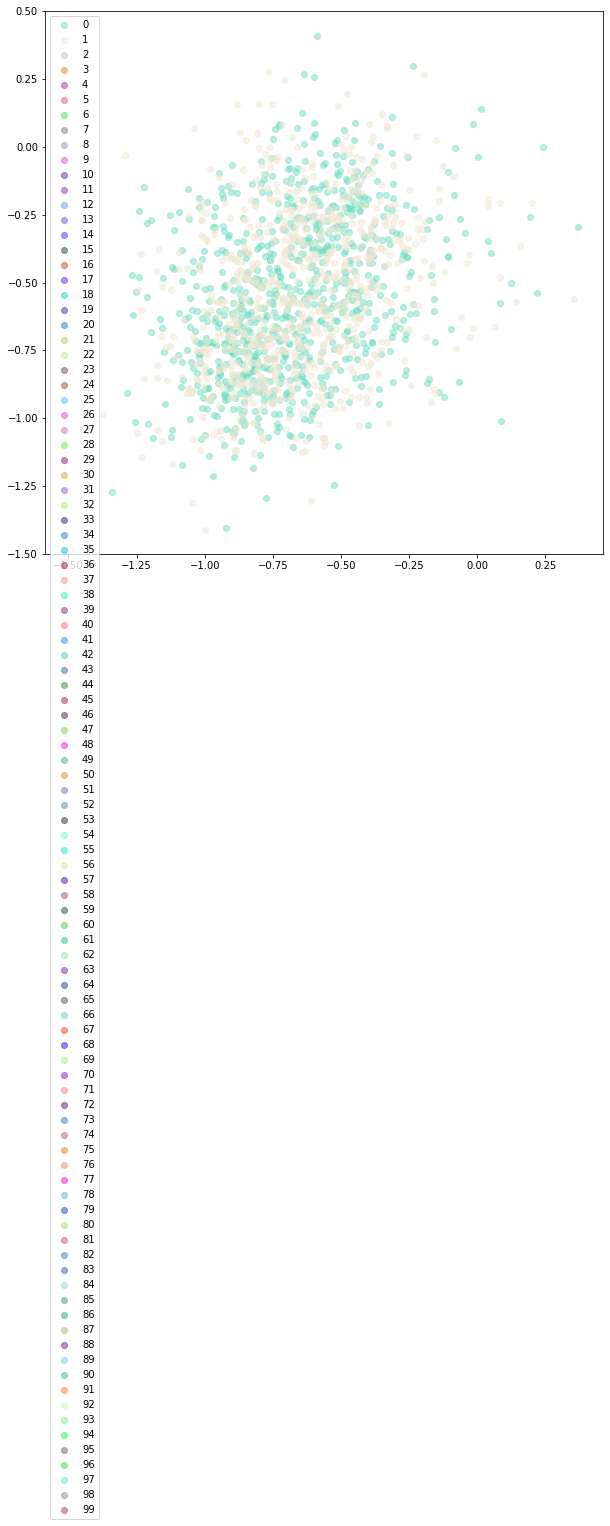

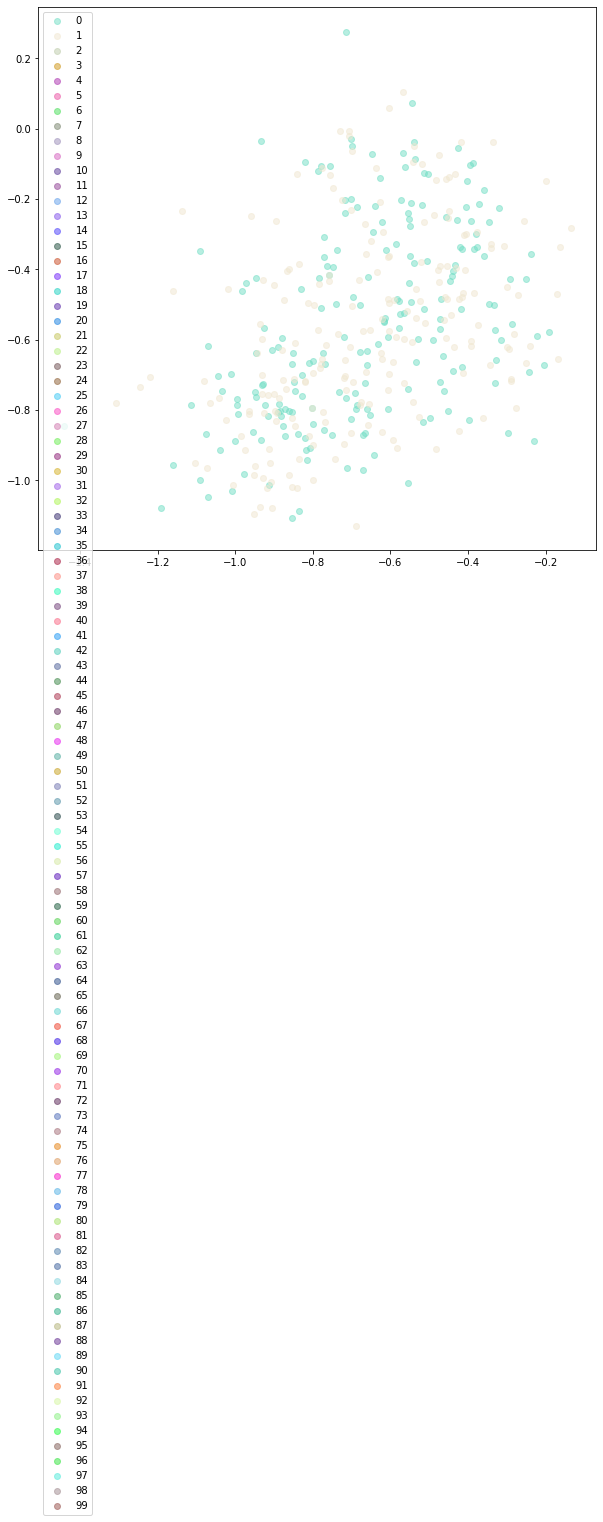

In [28]:
train_embeddings_cl, train_labels_cl = extract_embeddings(siamese_train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(siamese_test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)